In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
ab_testing = pd.read_csv("ab_data.csv")
ab_testing_control = ab_testing[ab_testing["group"] == "control"].copy()
ab_testing_treatment = ab_testing[ab_testing["group"] == "treatment"].copy()
print(ab_testing.head(10))
print(ab_testing.groupby("group").count())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1
5   936923  2017-01-10 15:20:49.083499    control     old_page          0
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1
7   719014  2017-01-17 01:48:29.539573    control     old_page          0
8   817355  2017-01-04 17:58:08.979471  treatment     new_page          1
9   839785  2017-01-15 18:11:06.610965  treatment     new_page          1
           user_id  timestamp  landing_page  converted
group                                                 
control     147202     147202        147202     147202
treatment   147276   

In [5]:
## Total records and unique users in the dataset
print(ab_testing.shape)
print(ab_testing["user_id"].nunique())

(294478, 5)
290584


In [6]:
## Proportion of users converted
(ab_testing.converted == 1).mean()*100

11.96591935560551

In [7]:
#identify misaligned rows
((ab_testing.group=='treatment') & (ab_testing.landing_page=='old_page')).sum()+ ((ab_testing.group=='control') & (ab_testing.landing_page=='new_page')).sum()
ab_testing['misaligned']=((ab_testing.group=='treatment') & (ab_testing.landing_page=='old_page')) | ((ab_testing.group=='control') & (ab_testing.landing_page=='new_page'))

In [8]:
ab_df = ab_testing[ab_testing["misaligned"] == False].copy()
print(ab_df.shape)

(290585, 6)


In [9]:
# Double Check all of the correct rows were removed - this should be 0
ab_df[((ab_df['group'] == 'treatment') == (ab_df['landing_page'] == 'new_page')) == False].shape[0]
print(ab_df['user_id'].nunique())
print(ab_df["user_id"].value_counts().sort_values(ascending = False).head())

290584
773192    2
639032    1
663620    1
778364    1
645179    1
Name: user_id, dtype: int64


In [10]:
ab_df[ab_df["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,False


In [11]:
ab_df = ab_df.drop(ab_df.index[1899])
print(ab_df.shape)

(290584, 6)


In [12]:
## What is the probability of an individual converting regardless of the page they receive?
print((ab_df["converted"] == 1).mean())

## Given that an individual was in the control group, what is the probability they converted?
actual_pold=(ab_df[ab_df["group"]=="control"]['converted']==1).mean()
print(actual_pold)

## Given that an individual was in the treatment group, what is the probability they converted?
actual_pnew=(ab_df[ab_df["group"]=="treatment"]['converted']==1).mean()
print(actual_pnew)

## What is the probability that an individual received the new page?
(ab_df['landing_page']=='new_page').mean()

0.11959708724499628
0.12038713319061353
0.11880724790277405


0.5000653855683727

In [13]:
pnew_null=(ab_df['converted']==1).mean()
print(pnew_null)

pold_null=(ab_df['converted']==1).mean()
print(pold_null)

n_new=(ab_df['landing_page']=='new_page').sum()
print(n_new)

n_old=(ab_df['landing_page']=='old_page').sum()
print(n_old)

0.11959708724499628
0.11959708724499628
145311
145273


In [14]:
new_page_converted=np.random.binomial(n_new, pnew_null)
old_page_converted=np.random.binomial(n_old, pold_null)
diff=(new_page_converted/n_new)-(old_page_converted/n_old)
print(diff)

-0.0001482764499928374


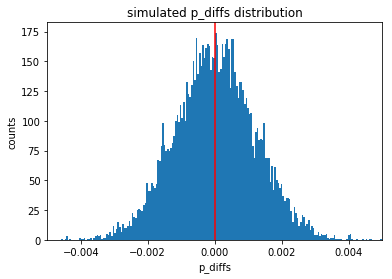

In [15]:
p_diffs=[]
p_diffs = np.random.binomial(n_new, pnew_null, 10000)/n_new - np.random.binomial(n_old, pold_null, 10000)/n_old 

plt.hist(p_diffs, bins=200)
plt.xlim(-0.005, 0.005)
plt.xlabel('p_diffs')
plt.ylabel('counts')
plt.title('simulated p_diffs distribution')
plt.axvline(0.000, color='red');

In [16]:
actual_diff=actual_pnew-actual_pold
(p_diffs>actual_diff).mean()

0.9086

In [17]:
import statsmodels.api as sm

convert_old = (ab_df.query('landing_page=="old_page"')['converted']==1).sum()
convert_new = (ab_df.query('landing_page=="new_page"')['converted']==1).sum()
n_old = (ab_df['landing_page']=='old_page').sum()
n_new=(ab_df['landing_page']=='new_page').sum()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145273, 145311)

In [18]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3122916566912053, 0.9052891269137592)

In [19]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.09471087308624082
1.6448536269514722


In [20]:
ab_df['intercept']=1
ab_df['ab_page']=pd.get_dummies(ab_df['group'])['treatment']
ab_df.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


In [21]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

lm=sm.Logit(ab_df['converted'], ab_df[['intercept', 'ab_page']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:               8.094e-06
Time:                        20:35:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1894
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.668      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.189      -0.037       0.007
==============================================================================
"""

In [22]:
## The intercept = -1.9888. exp(-1.9888)=0.13686. This means the conversion rate of baseline case is 0.13686.
## The coefficient for ab_page (treatment) is -0.015. exp(-0.015)=0.985. 1/0.985=1.015. This means that baseline (control that uses old_page) is 1.015 times likely to result in conversion relative to treatment.
## p value if 0.19. This is a large number compared to 0.05. Therefore I would not consider the results are statistically significant, and I fail to reject the null, which is that conversion rate does not depend on landing_page.

In [34]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import scikitplot as skplt

In [26]:
ab_testing_control = ab_testing[ab_testing["group"] == "control"].copy()
ab_testing_treatment = ab_testing[ab_testing["group"] == "treatment"].copy()

In [32]:
ab_testing_control.head(10)
ab_testing_control["ab_page"] = pd.get_dummies(ab_testing_control["landing_page"])['new_page']
ab_testing_treatment["ab_page"] = pd.get_dummies(ab_testing_treatment["landing_page"])['new_page']

features = ["ab_page"]

In [33]:
Y_train_control = ab_testing_control['converted']
X_train_control = ab_testing_control[features]

Y_train_exper = ab_testing_treatment['converted']
X_train_exper = ab_testing_treatment[features]

print(len(ab_testing_control))
print(len(ab_testing_treatment))

print(ab_testing_control['converted'].value_counts())
print(ab_testing_treatment['converted'].value_counts())


## print(train_control["treatment"].value_counts())
## print(train_exper["treatment"].value_counts())

from sklearn.cross_validation import train_test_split
X_treat_train, X_treat_test, y_treat_train, y_treat_test = train_test_split(X_train_exper, Y_train_exper, test_size = 0.4, stratify = Y_train_exper)
print(len(X_treat_train))
print(len(X_treat_test))
print(len(y_treat_train))
print(len(y_treat_test))
print((y_treat_train.value_counts()))
print((y_treat_test.value_counts()))


X_cont_train, X_cont_test, y_cont_train, y_cont_test = train_test_split(X_train_control, Y_train_control, test_size = 0.4, stratify = Y_train_control)
print(len(X_cont_train))
print(len(X_cont_test))
print(len(y_cont_train))
print(len(y_cont_test))
print((y_cont_train.value_counts()))
print((y_cont_test.value_counts()))

147202
147276
0    129479
1     17723
Name: converted, dtype: int64
0    129762
1     17514
Name: converted, dtype: int64
88365
58911
88365
58911
0    77857
1    10508
Name: converted, dtype: int64
0    51905
1     7006
Name: converted, dtype: int64
88321
58881
88321
58881
0    77687
1    10634
Name: converted, dtype: int64
0    51792
1     7089
Name: converted, dtype: int64


In [35]:
## Training the treatment model without upsample
model_control = linear_model.LogisticRegression()
model_control.fit(X_cont_train, y_cont_train)

## Training the treatment model without upsample
model_treatment = linear_model.LogisticRegression()
model_treatment.fit(X_treat_train, y_treat_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
## Making predictions on the test datasets for treatment and control without upsampling
control_test_pred = model_control.predict_proba(X_cont_test)
treatment_test_pred = model_control.predict_proba(X_treat_test)

In [37]:
## AUC calculations
from sklearn.metrics import roc_auc_score
auc_treatment = roc_auc_score(y_treat_test, treatment_test_pred[:,1])
print("Treatment AUC score:", auc_treatment)

auc_control = roc_auc_score(y_cont_test, control_test_pred[:,1])
print("Control AUC score:", auc_control)

Treatment AUC score: 0.49991686567636584
Control AUC score: 0.4991328721899545


C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\kalya\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


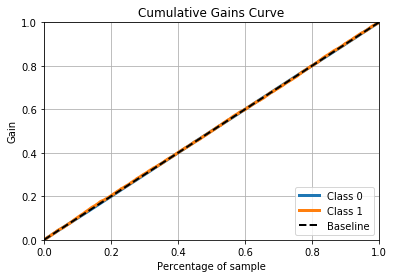

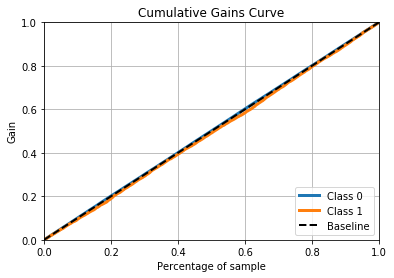

In [38]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_treat_test, treatment_test_pred)
skplt.metrics.plot_cumulative_gain(y_cont_test, control_test_pred)
plt.show()